In [ ]:
import pyspedas
#from pyqtgraph.graphicsItems.PlotDataItem import dataType
from pyspedas import tplot
import matplotlib.pyplot as plt
#import pandas as pd
import numpy as np


In [ ]:
pyspedas.projects.omni.data(trange=["2024-09-27/00:00:00", "2024-09-28/23:59:59"], datatype='1min', level='hro2', time_clip=True)

In [15]:
SPA_ID = pyspedas.get_data('IMF',dt = True)

In [16]:
#print(SPA_ID)

variable(times=array(['2024-09-27T00:00:00.000000000', '2024-09-27T00:01:00.000000000',
       '2024-09-27T00:02:00.000000000', ...,
       '2024-09-28T23:57:00.000000000', '2024-09-28T23:58:00.000000000',
       '2024-09-28T23:59:00.000000000'],
      shape=(2880,), dtype='datetime64[ns]'), y=array([52, 52, 52, ..., 52, 52, 52], shape=(2880,), dtype=int32))


In [17]:
upstream_wind = []
upstream_wind_time = []
upstream_ace = []
upstream_ace_time = []
upstream_other = []
upstream_other_time = []
for i in range(len(SPA_ID[1])):
    if SPA_ID[1][i] == 51 or 52:
        upstream_wind.append(omni_bz[1][i])
        upstream_wind_time.append(omni_bz[0][i])
    elif SPA_ID[1][i] == 71:
        upstream_ace.append(omni_bz[1][i])
        upstream_ace_time.append(omni_bz[0][i])
    else:
        upstream_other.append(omni_bz[1][i])
        upstream_other_time.append(omni_bz[0][i])



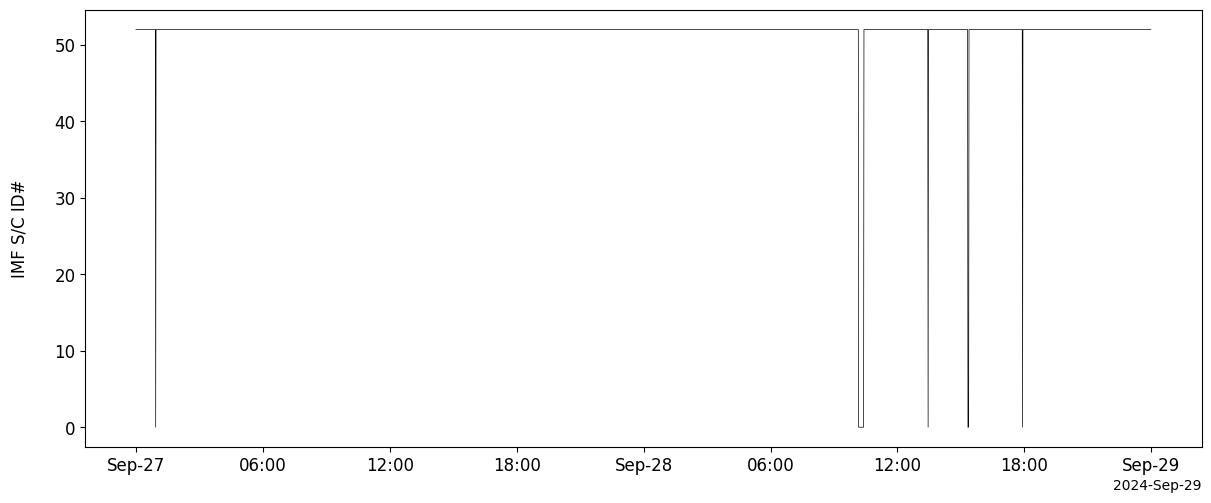

In [18]:
tplot(['IMF'])

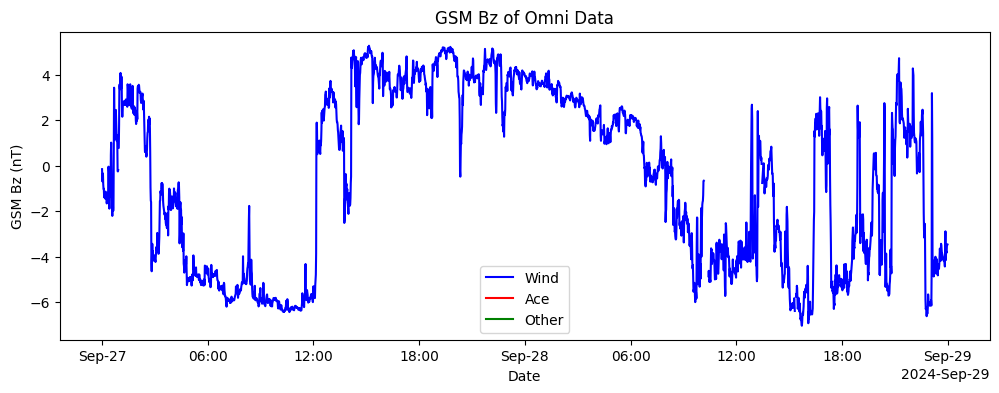

In [20]:
fig, ax = plt.subplots(figsize = (12,4))
plt.plot(upstream_wind_time, upstream_wind, label='Wind', color='blue', linestyle='-')
plt.plot(upstream_ace_time, upstream_ace, label='Ace', color='red', linestyle='-')
plt.plot(upstream_other_time, upstream_other, label='Other', color='green', linestyle='-')
plt.xlabel('Date')
plt.ylabel('GSM Bz (nT)')
plt.title('GSM Bz of Omni Data')
plt.legend()
plt.show()